In [1]:
import sys
import gc

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from datasets import Dataset

from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [2]:
test = pd.read_csv('test_essays.csv')
sub = pd.read_csv('sample_submission.csv')
org_train = pd.read_csv('train_essays.csv')

train = pd.read_csv("train_v2_drcat_02.csv", sep=',')

In [3]:
train = train.drop_duplicates(subset=['text'])

train.reset_index(drop=True, inplace=True)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [5]:
train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


Text(0.5, 1.0, 'Distribution of Generated Text')

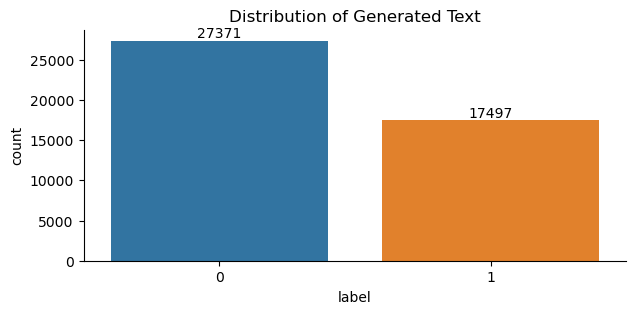

In [6]:
f, ax = plt.subplots(figsize=(7, 3))

sns.despine()
ax = sns.countplot(data=train,
                   x="label")

abs_values = train['label'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [7]:
train["text_length"] = train["text"].apply(lambda x : len(x.split()))

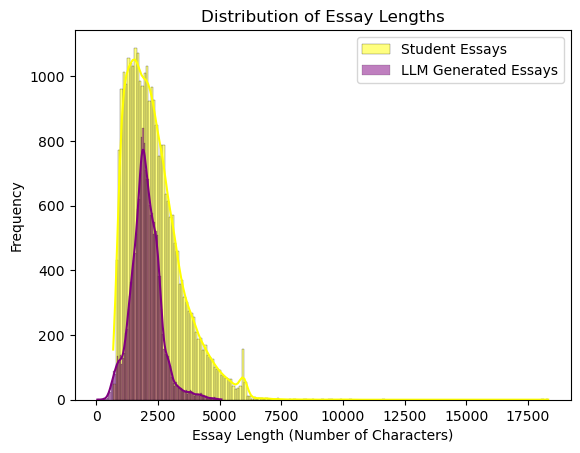

In [8]:
train['essay_length'] = train['text'].apply(len)
sns.histplot(train[train['label'] == 0]['essay_length'], color="yellow", label='Student Essays', kde=True)
sns.histplot(train[train['label'] == 1]['essay_length'], color="purple", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [9]:
train["text_length"].mean() + train["text_length"].std()

548.5474649045658

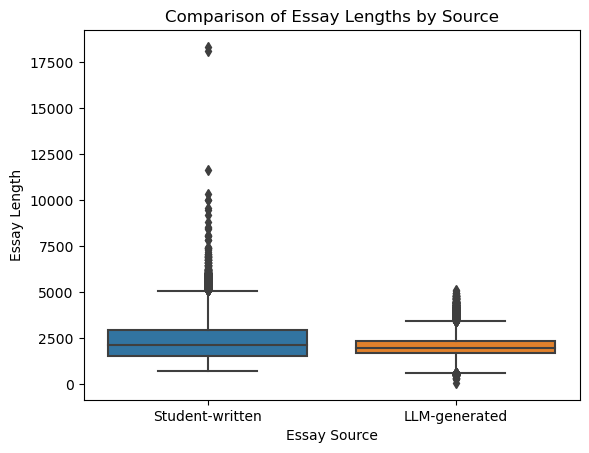

In [10]:
sns.boxplot(x='label', y='essay_length', data=train)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()

In [11]:
def calculate_text_metrics_simple(text):
    words = text.split()
    sentences = text.split('.')
    word_count = len(words)
    unique_word_count = len(set(words))
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sentence_count, avg_word_length


train['metrics'] = train['text'].apply(calculate_text_metrics_simple)
train[
    ['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']
] = pd.DataFrame(train['metrics'].tolist(), index=train.index)
train.drop('metrics', axis=1, inplace=True)

comparison_metrics = train.groupby('label')[
    ['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']
].mean()
comparison_metrics

,word_count,unique_word_count,sentence_count,avg_word_length
label,,,,
0,418.283146,199.858646,21.651748,4.531510
1,329.398983,169.369092,18.198891,5.093551


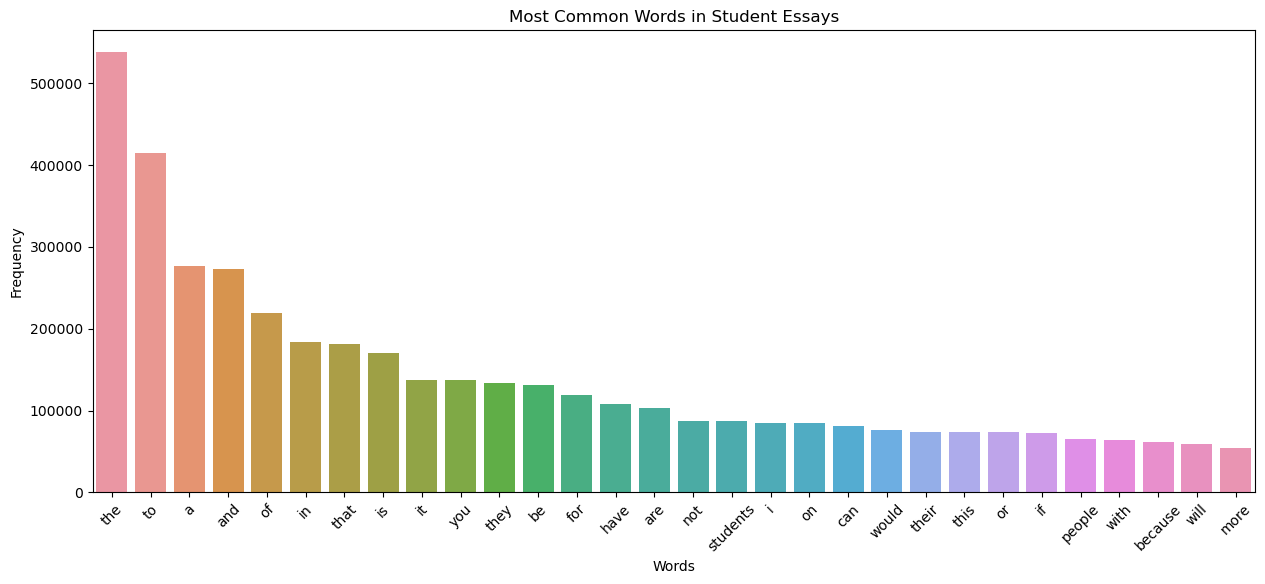

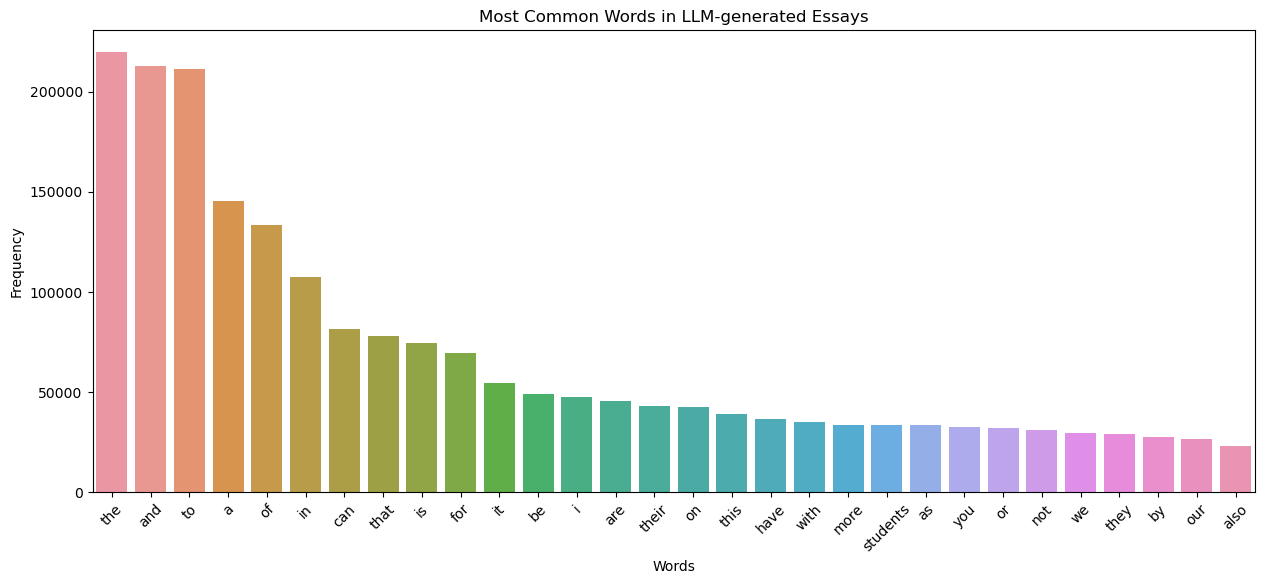

In [12]:
def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)

    # Plot the most common words
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

plot_most_common_words(train[train['label'] == 0]['text'], title="Most Common Words in Student Essays")
plot_most_common_words(train[train['label'] == 1]['text'], title="Most Common Words in LLM-generated Essays")

In [13]:
test.text.values

array(['Aaa bbb ccc.', 'Bbb ccc ddd.', 'CCC ddd eee.'], dtype=object)

In [14]:
LOWERCASE = False
VOCAB_SIZE = 30522

In [15]:
# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))


# Adding normalization and pre_tokenizer
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# Adding special tokens and creating trainer instance
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)



# Creating huggingface dataset object
dataset = Dataset.from_pandas(test[['text']])
def train_corp_iter():
    """
    A generator function for iterating over a dataset in chunks.
    """    
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

# Training from iterator REMEMBER it's training on test set...
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

tokenized_texts_test = []

# Tokenize test set with new tokenizer
for text in tqdm(test['text'].tolist()):
    tokenized_texts_test.append(tokenizer.tokenize(text))


# Tokenize train set
tokenized_texts_train = []

for text in tqdm(train['text'].tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/44868 [00:00<?, ?it/s]

In [16]:
tokenized_texts_test[1]

['ĠBbb', 'Ġccc', 'Ġddd', '.']

In [17]:
def dummy(text):
    """
    A dummy function to use as tokenizer for TfidfVectorizer. It returns the text as it is since we already tokenized it.
    """
    return text

In [18]:
# Fitting TfidfVectoizer on test set

vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, strip_accents='unicode'
                            )

vectorizer.fit(tokenized_texts_test)

# Getting vocab
vocab = vectorizer.vocabulary_

print(vocab)

# Here we fit our vectorizer on train set but this time we use vocabulary from test fit.
vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode'
                            )

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer
gc.collect()

{'ĠAaa Ġbbb Ġccc': 0, 'Ġbbb Ġccc .': 6, 'ĠAaa Ġbbb Ġccc .': 1, 'ĠBbb Ġccc Ġddd': 2, 'Ġccc Ġddd .': 7, 'ĠBbb Ġccc Ġddd .': 3, 'ĠCCC Ġddd Ġeee': 4, 'Ġddd Ġeee .': 8, 'ĠCCC Ġddd Ġeee .': 5}


38647

In [19]:
y_train = train['label'].values

In [20]:
tf_train

<44868x9 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [21]:
tf_train.shape

(44868, 9)

In [22]:
tf_test.shape

(3, 9)

In [23]:
import xgboost as xgb

In [24]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [25]:

sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

clf = MultinomialNB(alpha=0.02)

In [26]:
 weights = [0.3,0.1,0.15,0.15,0.3]
 
 ensemble = VotingClassifier(estimators=[('xg',xgb_model),
                                            ('sgd', sgd_model),
                                            ('rf',rf_model), 
                                            ('gb', gb_model),
                                            ('cl',clf)
                                           ],
                                weights=weights, voting='soft', n_jobs=-1)
ensemble.fit(tf_train, y_train)
gc.collect()
final_preds = ensemble.predict_proba(tf_test)[:,1]
sub['generated'] = final_preds
sub.to_csv('submission.csv', index=False)
sub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,id,generated
0,0000aaaa,0.38979
1,1111bbbb,0.38979
2,2222cccc,0.38979
